<a href="https://colab.research.google.com/github/geexe/stock-price-classification-sell-buy/blob/main/DADS6003_Final_Project_Stock_Price_Buy_Sell_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Prediction of Stock Price direction**

### Installations

In [ ]:
!pip install pandas
!pip install numpy
!pip install requests
!pip install lxml
!pip install yfinance

In [ ]:
# Resolve "cannot install ta-lib"
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib

In [ ]:
# Algorithms to be used
from sklearn.linear_model import *
from sklearn.neural_network import *
from sklearn.naive_bayes import *
from sklearn.neighbors import *
from sklearn.ensemble import *
from sklearn.tree import *
from sklearn.svm import *

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Model Seclection
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import *
from sklearn.feature_selection import *
from sklearn import metrics
from sklearn.model_selection import cross_val_score

# import other required libraries
from pandas_datareader import data as pdr
import yfinance as yf
import talib as ta
import numpy as np
import pandas as pd
#from sklearn.externals import joblib
import joblib
from google.colab import files

# import other libraries for EDA
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#print(df.describe())
'''df2 = pd.DataFrame()

df2['Shift'] = df['Close'].shift(-1)
df2['not_shift'] = df["Close"]
print(df2)'''

'df2 = pd.DataFrame()\n\ndf2[\'Shift\'] = df[\'Close\'].shift(-1)\ndf2[\'not_shift\'] = df["Close"]\nprint(df2)'

### Feature engineering and Functions

In [ ]:
# Get Ticker Data at specified start date, end date and interval
def get_data(ticker,start_date,end_date,query_interval):
  yf.pdr_override()
  quote = yf.Ticker(ticker)
  interval = query_interval
  start = start_date
  end = end_date
  quote_price_df = quote.history(interval=interval,start=start,end=end)
  df = quote_price_df.iloc[:,:4]
  return df

# Add features to Data Frame
def add_features(df):
  df = df.reset_index()
  df = df.iloc[:,:5]
  df['S_10'] = df['Close'].rolling(window=10).mean()
  #df['Corr'] = df['Close'].rolling(window=10).corr(df['S_10'])
  df['RSI'] = ta.RSI(np.array(df['Close']), timeperiod =10)
  df['Open-Close'] = df['Open'] - df['Close'].shift(1)
  df['Open-Open'] = df['Open'] - df['Open'].shift(1)
  df['%K'], df['%D'] = ta.STOCH(df['High'], df['Low'], df['Close'])
  # df['%K'], df['%D'] = df['%K']/100, df['%D']/100
  df['UpperBand'], df['MiddleBand'], df['LowerBand'] = ta.BBANDS(df['Close'])
  # Replace upper and lower bolliger bands with the differences to the 'Close'
  df['UpperBand'] = df['UpperBand'] - df['Close']
  df['LowerBand'] = df['UpperBand'] - df['Close']
  df['Reverse_buy'] = np.where(df['High'].shift(2) < df['Close'], 1, 0)
  df['Reverse_sell'] = np.where(df['Low'].shift(2) > df['Close'], 1, 0)
  # Convert the 'Date' column to datetime
  if 'Datetime' in df.columns:
    # Since the column name changes according to the time frame given to the Yahoo Finance API:
    # "Date" if time frame is >1d, otherwise "Datetime" if <1d, we need to select the right column
    df['Date'] = pd.to_datetime(df['Datetime'])
  else:
    df['Date'] = pd.to_datetime(df['Date'])
  # Convert day of week to circular function (x,y) coordinates in a 2-dimension space using sin() and cos()
  df['Day_of_Week'] = df['Date'].dt.dayofweek
  df['Circular_Day_Sine'] = np.sin(2 * np.pi * df['Day_of_Week'] / 7)
  df['Circular_Day_Cosine'] = np.cos(2 * np.pi * df['Day_of_Week'] / 7)
  df['Is_Friday'] = (df['Day_of_Week'] == 4).astype(int)
  df['Is_Monday'] = (df['Day_of_Week'] == 0).astype(int)
  # Extract hour and minute from the datetime
  df['Hour'] = df['Date'].dt.hour
  df['Minute'] = df['Date'].dt.minute
  df['Is_10am'] = (df['Hour'] == 10).astype(int)
  df['Is_4pm'] = (df['Hour'] == 16).astype(int)
  # Convert time of day to circular values using sine and cosine
  df['Circular_Time_Sine'] = np.sin(2 * np.pi * (df['Hour'] * 60 + df['Minute']) / (24 * 60))
  df['Circular_Time_Cosine'] = np.cos(2 * np.pi * (df['Hour'] * 60 + df['Minute']) / (24 * 60))
  # Drop variables
  df = df.drop('Day_of_Week', axis = 1)
  df = df.drop('Hour', axis = 1)
  df = df.drop('Minute', axis = 1)
  df = df.drop('MiddleBand', axis = 1)
  if 'Datetime' in df.columns:
    df = df.drop('Datetime', axis = 1)
    df = df.drop('Date', axis = 1)
  else:
    df = df.drop('Date', axis = 1)

  df = df.dropna()
  return df

def define_var(data,split_proportion):
  # Define y
  # Shift -1 means data from the next period is put into the current row: means if the next period price is higher, we buy
  # Shift 1 means data from the previous period is put into the current row: means if the previous period price is higher, we sell
  X = data
  y = np.where(data['Close'].shift(-1) > data['Close'],1,0)

  buy = int(0)
  not_buy = int(0)
  for i in range(len(y)):
    if y[i] == 1:
      buy += 1
    else:
      not_buy += 1

  split = int(split_proportion * len(data))
  X_train, X_test, y_train, y_test = data[:split], data[split:], y[:split], y[split:]
  return X_train, X_test, y_train, y_test

# Define train or test data (No splitting)
def define_data(data):
# Define y
  # Shift -1 means data from the next period is put into the current row: means if the next period price is higher, we buy
  # Shift 1 means data from the previous period is put into the current row: means if the previous period price is higher, we sell
  X = data
  y = np.where(data['Close'].shift(-1) > data['Close'],1,-1)

  buy = int(0)
  not_buy = int(0)
  for i in range(len(y)):
    if y[i] == 1:
      buy += 1
    else:
      not_buy += 1

  return X, y

# Define train or test data (No splitting)
def define_data1(data):
# Define y
  # Shift -1 means data from the next period is put into the current row: means if the next period price is higher, we buy
  # Shift 1 means data from the previous period is put into the current row: means if the previous period price is higher, we sell
  X = data
  y = np.where(data['Close'].shift(-1) > data['Close'],1,-1)

  buy = int(0)
  not_buy = int(0)
  for i in range(len(y)):
    if y[i] == 1:
      buy += 1
    else:
      not_buy += 1

  return X, y, buy, not_buy

# GridSearch
def grid_search(modelType, X_train, y_train, gridParam, cv_fold,):
  grid = GridSearchCV(modelType,gridParam,cv=cv_fold)
  grid.fit(X_train, y_train)
  best_model = grid.best_estimator_
  return best_model

# Build model and output report (Input gridseach 'best_model' for modelType). However, this is not recommended as GridSearchCV uses the same training data
# Use nested_cv instead for GridSearch and model evaluation with 2-step CV
def train_model(modelType, X_train, X_test, y_train, y_test):

  model = modelType
  model.fit(X_train, y_train)

  y_pred = model.predict(X_test)
  y_prob = model.predict_proba(X_test)[:,1]

  conf_matrix = metrics.confusion_matrix(y_test, y_pred)

  #Classification Report
  report = metrics.classification_report(y_test, y_pred)

  # Model Accuracy
  accuracy = model.score(X_test,y_test)

  # Cross Validation
  cross_val = cross_val_score(modelType, X_train, y_train, scoring = 'roc_auc', cv = 5)

  # AUC_ROC
  auc_score = roc_auc_score(y_test, y_prob)

  return X_train, X_test, y_train, y_test, y_pred, model, conf_matrix, report, accuracy, cross_val, auc_score

# Nested Cross-Validation
def nested_cv(modelType, X, y, gridParam, outerCvFold, innerCvFold,state):
    # Outer cross-validation (for model evaluation)
  outer_cv = StratifiedKFold(n_splits=outerCvFold, shuffle=True, random_state=state)

  # Inner cross-validation (for hyperparameter tuning)
  inner_cv = StratifiedKFold(n_splits=innerCvFold, shuffle=True,random_state=state)

  # Nested cross-validation
  nested_scores = []

  for train_index, test_index in outer_cv.split(X, y):

    # X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:] # X is pandas DataFrame so need to use .iloc[Slice,Slice]
    X_train, X_test = X[train_index], X[test_index] # X is pandas DataFrame so need to use .iloc[Slice,Slice]
    y_train, y_test = y[train_index], y[test_index] # y is np array so can use index directly

    # GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(estimator=modelType, param_grid=gridParam, scoring='roc_auc', cv=inner_cv)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    # Evaluate the model on the outer test set
    outer_score = grid_search.score(X_test, y_test)
    nested_scores.append(outer_score)
  return best_model, nested_scores

### SPRC

In [ ]:
# SPRC - Nested CV
# df_train = get_data('ERW.BK','2022-01-25','2023-01-05','1h')
df_train = get_data('SPRC.BK','2022-01-15','2024-01-02','1h')
df_test = get_data('SPRC.BK','2024-01-03','2024-01-13','15m')
df_train = add_features(df_train)
df_test = add_features(df_test)
X_train, y_train, buy, not_buy = define_data1(df_train)
X_test, y_test = define_data(df_test)
X_train = np.array(X_train)
scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.fit_transform(X_test)

models = [
  [LogisticRegression(max_iter = 10000, solver = 'liblinear'), {'C': np.logspace(0,-9,30)}],
  [KNeighborsClassifier(), {'n_neighbors' : [5,6,7,8,9,10,11,12,13,14,15]}],
  [GaussianNB(), {'priors' : [None,[0.5,0.5],[buy/(buy+not_buy), not_buy/(buy+not_buy)],[not_buy/(buy+not_buy), buy/(buy+not_buy)]]}],
  [RandomForestClassifier(), {'n_estimators': [50,100,150], 'max_depth' : [10, 20], 'min_samples_split': [2, 5]}],
  [MLPClassifier(max_iter = 5000), {'hidden_layer_sizes': [(2,),(3,),(4,)]}]
]

LogReg = LogisticRegression(max_iter = 10000)
LogReg.fit(X_train, y_train)
CV_score = cross_val_score(LogReg, X_train,y_train,scoring="roc_auc",cv=10)
y_pred0 = LogReg.predict_proba(X_test)[:,1]
auc_logreg = roc_auc_score(y_test,y_pred0)
print("Base Score for Logistic Regression with default hyperparameter")
print(CV_score.mean(), "|", CV_score)
print("AUC Test: ", auc_logreg)

out_model_sprc = []

for m in models:
  grid_param = m[1]
  best_model, nested_scores = nested_cv(m[0], X_train, y_train, grid_param, 10, 5, 24)
  print("*************", best_model, "*************")
  print(f"Mean CV - AUC: \033[1m{round(np.mean(nested_scores),3)}\033[0m +- {round(np.std(nested_scores)/np.sqrt(len(nested_scores)) ,3)} | {[round(x,3) for x in nested_scores]}")
  y_pred = best_model.predict_proba(X_test)[:,1]
  y_pred_val = best_model.predict(X_test)
  auc_score = round(roc_auc_score(y_test, y_pred),3)
  print("Test AUC: ", auc_score)
  conf_matrix = metrics.confusion_matrix(y_test, y_pred_val)
  print("Confusion Matrix:\n", conf_matrix)
  out_model_sprc.append([best_model,auc_score])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Base Score for Logistic Regression with default hyperparameter
0.6270555762826624 | [0.60576697 0.62802443 0.71112286 0.63090204 0.65045807 0.63636364
 0.62297393 0.57775429 0.59518717 0.61200238]
AUC Test:  0.6743886743886744
************* LogisticRegression(max_iter=10000, solver='liblinear') *************
Mean CV - AUC: 0.628 +- 0.014 | [0.593, 0.532, 0.656, 0.608, 0.646, 0.596, 0.627, 0.686, 0.668, 0.671]
Test AUC:  0.678
Confusion Matrix:
 [[103   2]
 [ 37   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


************* KNeighborsClassifier(n_neighbors=15) *************
Mean CV - AUC: 0.547 +- 0.013 | [0.557, 0.457, 0.513, 0.526, 0.608, 0.556, 0.591, 0.554, 0.541, 0.569]
Test AUC:  0.566
Confusion Matrix:
 [[96  9]
 [32  5]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


************* GaussianNB() *************
Mean CV - AUC: 0.567 +- 0.015 | [0.552, 0.463, 0.622, 0.579, 0.584, 0.503, 0.591, 0.578, 0.614, 0.58]
Test AUC:  0.645
Confusion Matrix:
 [[91 14]
 [27 10]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


************* RandomForestClassifier(max_depth=10, n_estimators=150) *************
Mean CV - AUC: 0.578 +- 0.012 | [0.595, 0.487, 0.575, 0.551, 0.58, 0.562, 0.569, 0.616, 0.627, 0.618]
Test AUC:  0.536
Confusion Matrix:
 [[103   2]
 [ 36   1]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


************* MLPClassifier(hidden_layer_sizes=(2,), max_iter=5000) *************
Mean CV - AUC: 0.558 +- 0.019 | [0.516, 0.456, 0.622, 0.497, 0.621, 0.53, 0.619, 0.6, 0.51, 0.613]
Test AUC:  0.602
Confusion Matrix:
 [[103   2]
 [ 37   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


In [ ]:
out_model_sprc

[[LogisticRegression(max_iter=10000, solver='liblinear'), 0.667],
 [KNeighborsClassifier(n_neighbors=14), 0.475],
 [GaussianNB(), 0.657],
 [RandomForestClassifier(max_depth=10), 0.494],
 [MLPClassifier(hidden_layer_sizes=(4,), max_iter=5000), 0.612]]

### TISCO

In [ ]:
# TISCO Experiment - Nested CV
# df_train = get_data('ERW.BK','2022-01-25','2023-01-05','1h')
df_train = get_data('TISCO.BK','2023-11-16','2023-12-28','15m')
df_test = get_data('TISCO.BK','2023-12-29','2024-01-13','15m')
df_train = add_features(df_train)
df_test = add_features(df_test)
scaler = StandardScaler()
X_train, y_train, buy, not_buy = define_data1(df_train)
X_test, y_test = define_data(df_test)
X_train = np.array(X_train)
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.fit_transform(X_test)

models = [
  [LogisticRegression(max_iter = 10000, solver = 'liblinear'), {'C': np.logspace(0,-9,30)}],
  [KNeighborsClassifier(), {'n_neighbors' : [5,6,7,8,9,10,11,12,13,14,15]}],
  [GaussianNB(), {'priors' : [None, [0.5,0.5],[buy/(buy+not_buy), not_buy/(buy+not_buy)],[not_buy/(buy+not_buy), buy/(buy+not_buy)]]}],
  [RandomForestClassifier(), {'n_estimators': [50,100,150], 'max_depth' : [10, 20], 'min_samples_split': [2, 5]}],
  [MLPClassifier(max_iter = 5000), {'hidden_layer_sizes': [(2,),(3,),(4,),(5,)], 'alpha': np.logspace(0,-7,8)}]
]

LogReg = LogisticRegression(max_iter = 10000)
LogReg.fit(X_train, y_train)
CV_score = cross_val_score(LogReg, X_train,y_train,scoring="roc_auc")
y_pred0 = LogReg.predict_proba(X_test)[:,1]
auc_logreg = roc_auc_score(y_test,y_pred0)
print("Base Score for Logistic Regression with default hyperparameter")
print(CV_score.mean(), "|", CV_score)
print("AUC Test: ", auc_logreg)

out_model_tisco = []

for m in models:
  grid_param = m[1]
  best_model, nested_scores = nested_cv(m[0], X_train, y_train, grid_param, 10, 5, 24)
  print("*************", best_model, "*************")
  print(f"Mean CV - AUC: \033[1m{round(np.mean(nested_scores),3)}\033[0m +- {round(np.std(nested_scores)/np.sqrt(len(nested_scores)), 3)} | {[round(x,3) for x in nested_scores]}")
  y_pred = best_model.predict_proba(X_test)[:,1]
  y_pred_val = best_model.predict(X_test)
  auc_score = round(roc_auc_score(y_test, y_pred),3)
  print("Test AUC: ", auc_score)
  conf_matrix = metrics.confusion_matrix(y_test, y_pred_val)
  print("Confusion Matrix:\n", conf_matrix)
  out_model_tisco.append([best_model,auc_score])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Base Score for Logistic Regression with default hyperparameter
0.7768977320675107 | [0.8095     0.651      0.8234375  0.81979167 0.78075949]
AUC Test:  0.8172043010752688
************* LogisticRegression(max_iter=10000, solver='liblinear') *************
Mean CV - AUC: 0.788 +- 0.027 | [0.854, 0.81, 0.785, 0.587, 0.812, 0.829, 0.933, 0.767, 0.733, 0.769]
Test AUC:  0.822
Confusion Matrix:
 [[92 19]
 [12 19]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


************* KNeighborsClassifier(n_neighbors=7) *************
Mean CV - AUC: 0.715 +- 0.02 | [0.751, 0.692, 0.684, 0.601, 0.829, 0.741, 0.808, 0.67, 0.685, 0.691]
Test AUC:  0.744
Confusion Matrix:
 [[96 15]
 [18 13]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


************* GaussianNB() *************
Mean CV - AUC: 0.711 +- 0.028 | [0.738, 0.721, 0.771, 0.517, 0.767, 0.738, 0.844, 0.742, 0.608, 0.661]
Test AUC:  0.791
Confusion Matrix:
 [[110   1]
 [ 30   1]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


************* RandomForestClassifier(max_depth=10) *************
Mean CV - AUC: 0.741 +- 0.027 | [0.787, 0.783, 0.648, 0.567, 0.79, 0.788, 0.892, 0.735, 0.748, 0.679]
Test AUC:  0.74
Confusion Matrix:
 [[111   0]
 [ 31   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


************* MLPClassifier(alpha=1e-05, hidden_layer_sizes=(2,), max_iter=5000) *************
Mean CV - AUC: 0.613 +- 0.059 | [0.269, 0.5, 0.808, 0.535, 0.423, 0.81, 0.888, 0.719, 0.656, 0.525]
Test AUC:  0.768
Confusion Matrix:
 [[106   5]
 [ 24   7]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


In [ ]:
out_model_tisco

[[LogisticRegression(max_iter=10000, solver='liblinear'), 0.822],
 [KNeighborsClassifier(n_neighbors=7), 0.744],
 [GaussianNB(), 0.791],
 [RandomForestClassifier(max_depth=10), 0.74],
 [MLPClassifier(alpha=1e-05, hidden_layer_sizes=(2,), max_iter=5000), 0.768]]

### ERW

In [ ]:
# ERW Experiment - Nested CV
# df_train = get_data('ERW.BK','2022-01-25','2023-01-05','1h')
df_train = get_data('ERW.BK','2023-11-15','2023-12-28','15m')
df_test = get_data('ERW.BK','2023-12-29','2024-01-13','15m')
df_train = add_features(df_train)
df_test = add_features(df_test)
scaler = StandardScaler()
X_train, y_train, buy, not_buy = define_data1(df_train)
X_test, y_test = define_data(df_test)
X_train = np.array(X_train)
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.fit_transform(X_test)

models = [
  [LogisticRegression(max_iter = 10000, solver = 'liblinear'), {'C': np.logspace(0,-9,30)}],
  [KNeighborsClassifier(), {'n_neighbors' : [5,6,7,8,9,10,11,12,13,14,15]}],
  [GaussianNB(), {'priors' : [None, [0.5,0.5],[buy/(buy+not_buy), not_buy/(buy+not_buy)],[not_buy/(buy+not_buy), buy/(buy+not_buy)]]}],
  [RandomForestClassifier(), {'n_estimators': [50,100,150], 'max_depth' : [10, 20], 'min_samples_split': [2, 5]}],
  [MLPClassifier(max_iter = 5000), {'hidden_layer_sizes': [(2,),(3,),(4,)]}]
]

LogReg = LogisticRegression(max_iter = 10000)
LogReg.fit(X_train, y_train)
CV_score = cross_val_score(LogReg, X_train,y_train,scoring="roc_auc")
y_pred0 = LogReg.predict_proba(X_test)[:,1]
auc_logreg = roc_auc_score(y_test,y_pred0)
print("Base Score for Logistic Regression with default hyperparameter")
print(CV_score.mean(), "|", CV_score)
print("AUC Test: ", auc_logreg)

out_model_erw = []

for m in models:
  grid_param = m[1]
  best_model, nested_scores = nested_cv(m[0], X_train, y_train, grid_param, 10, 5, 888)
  print("*************", best_model, "*************")
  print(f"Mean CV - AUC: \033[1m{round(np.mean(nested_scores),3)}\033[0m +- {round(np.std(nested_scores)/np.sqrt(len(nested_scores)), 3)} | {[round(x,3) for x in nested_scores]}")
  y_pred = best_model.predict_proba(X_test)[:,1]
  y_pred_val = best_model.predict(X_test)
  auc_score = round(roc_auc_score(y_test, y_pred),3)
  print(f"Test AUC: \033[1m{auc_score}\033[0m")
  conf_matrix = metrics.confusion_matrix(y_test, y_pred_val)
  print("Confusion Matrix:\n", conf_matrix)
  out_model_erw.append([best_model,auc_score])
  # print("Classification Report:\n", report)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Base Score for Logistic Regression with default hyperparameter
0.6789285092302333 | [0.73051948 0.71477273 0.64943182 0.62613636 0.67378216]
AUC Test:  0.7791353383458647
************* LogisticRegression(C=0.117210229753348, max_iter=10000, solver='liblinear') *************
Mean CV - AUC: 0.67 +- 0.033 | [0.81, 0.534, 0.598, 0.861, 0.632, 0.627, 0.643, 0.78, 0.577, 0.634]
Test AUC: 0.745
Confusion Matrix:
 [[110   4]
 [ 24   4]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


************* KNeighborsClassifier(n_neighbors=13) *************
Mean CV - AUC: 0.639 +- 0.029 | [0.779, 0.445, 0.542, 0.743, 0.618, 0.588, 0.668, 0.695, 0.66, 0.648]
Test AUC: 0.635
Confusion Matrix:
 [[112   2]
 [ 24   4]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


************* GaussianNB() *************
Mean CV - AUC: 0.668 +- 0.027 | [0.76, 0.582, 0.64, 0.705, 0.618, 0.734, 0.718, 0.736, 0.468, 0.715]
Test AUC: 0.699
Confusion Matrix:
 [[82 32]
 [14 14]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


************* RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=50) *************
Mean CV - AUC: 0.654 +- 0.023 | [0.731, 0.6, 0.624, 0.716, 0.709, 0.702, 0.623, 0.745, 0.555, 0.537]
Test AUC: 0.718
Confusion Matrix:
 [[109   5]
 [ 24   4]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


************* MLPClassifier(hidden_layer_sizes=(4,), max_iter=5000) *************
Mean CV - AUC: 0.585 +- 0.046 | [0.833, 0.527, 0.514, 0.909, 0.507, 0.489, 0.535, 0.489, 0.5, 0.55]
Test AUC: 0.556
Confusion Matrix:
 [[111   3]
 [ 25   3]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


In [ ]:
out_model_erw

[[LogisticRegression(C=0.23950266199874853, max_iter=10000, solver='liblinear'),
  0.766],
 [KNeighborsClassifier(n_neighbors=12), 0.657],
 [GaussianNB(), 0.732],
 [RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=50),
  0.701],
 [MLPClassifier(hidden_layer_sizes=(3,), max_iter=5000), 0.5]]



# Estimator SPRC



In [ ]:
joblib.dump(out_model_sprc[0][0], 'model_sprc.joblib')
files.download('model_sprc.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
out_model_sprc[0][0]

LogisticRegression(max_iter=10000, solver='liblinear')

# Estimator TISCO

In [ ]:
joblib.dump(out_model_tisco[0][0], 'model_tisco.joblib')
files.download('model_tisco.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
out_model_tisco[0][0]

LogisticRegression(max_iter=10000, solver='liblinear')

# Estimator ERW

In [ ]:
joblib.dump(out_model_erw[0][0], 'model_erw.joblib')
files.download('model_erw.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
out_model_erw[0][0]

LogisticRegression(C=0.117210229753348, max_iter=10000, solver='liblinear')

### EDA

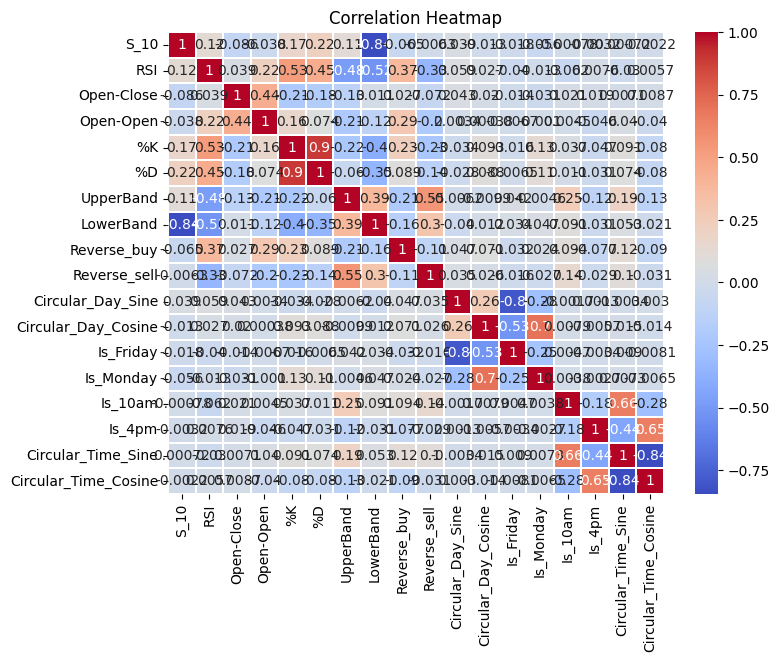

In [ ]:
# EDA - Correlation of features heat map
correlation_matrix = df_train.iloc[:,4:].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.1)
plt.title('Correlation Heatmap')
plt.show()

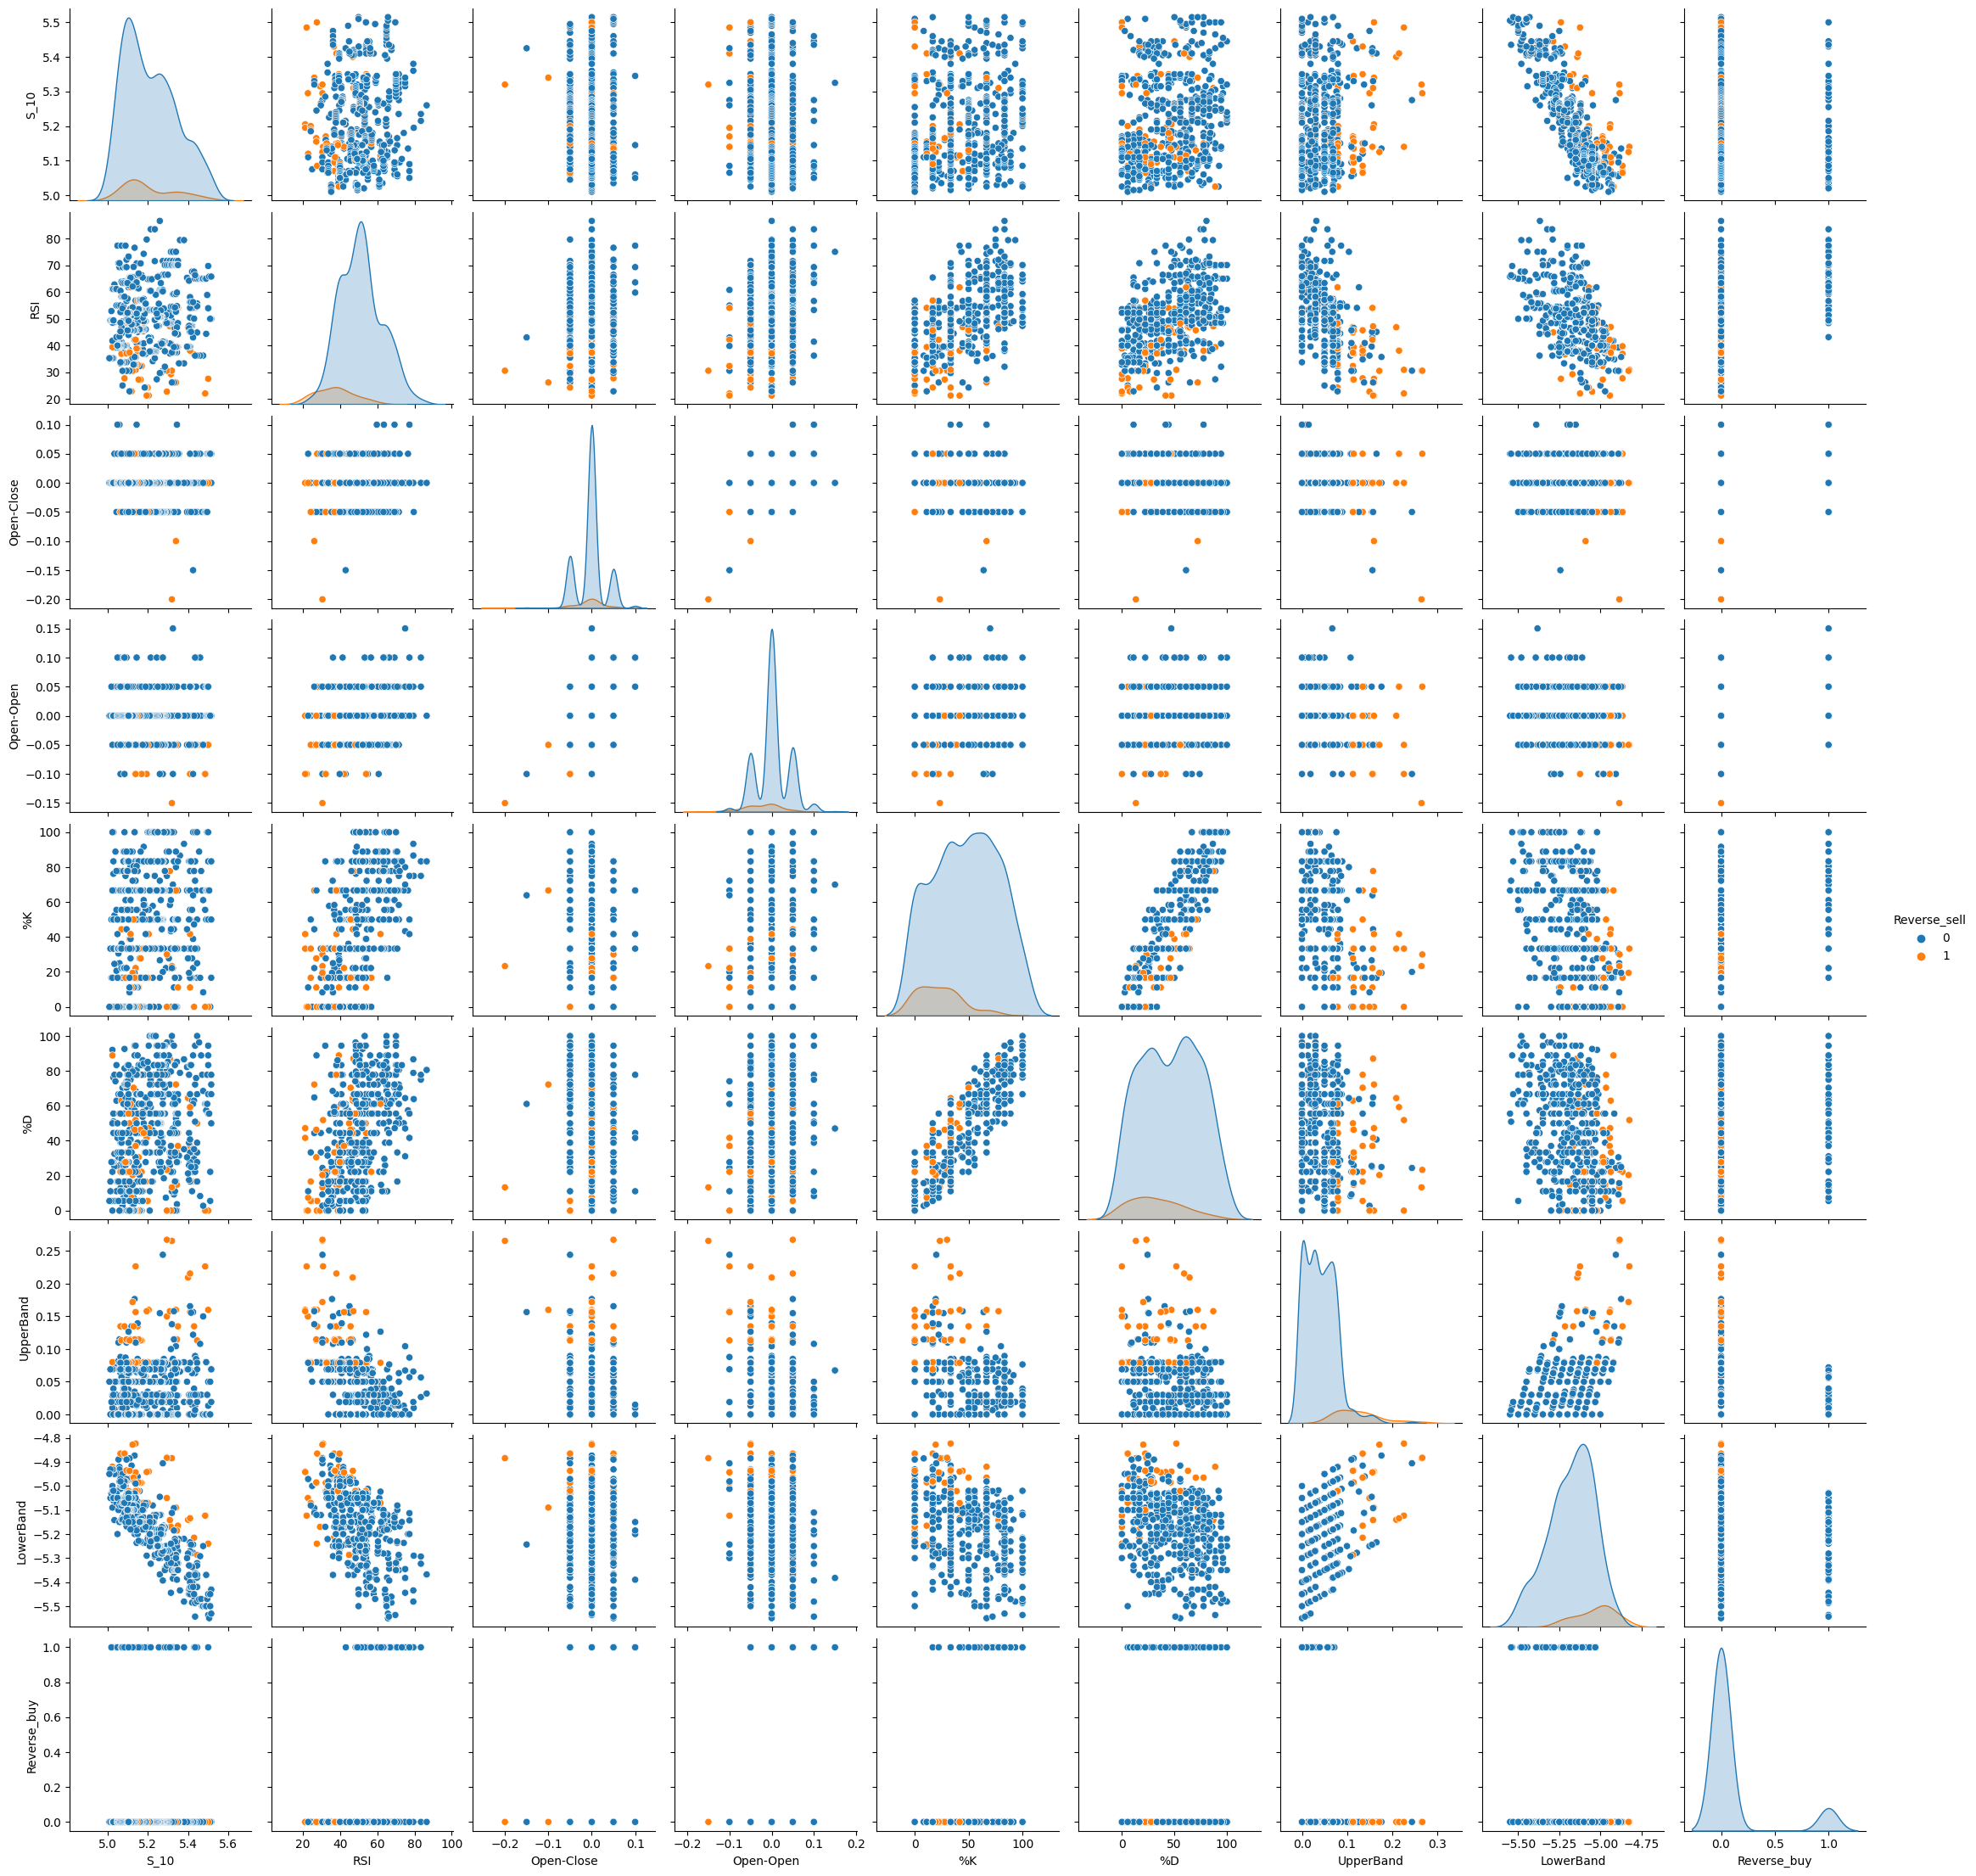

In [ ]:
# EDA - Pair plot between features
sns.pairplot(df_train.iloc[:,4:14], hue = 'Reverse_sell', diag_kind="kde")

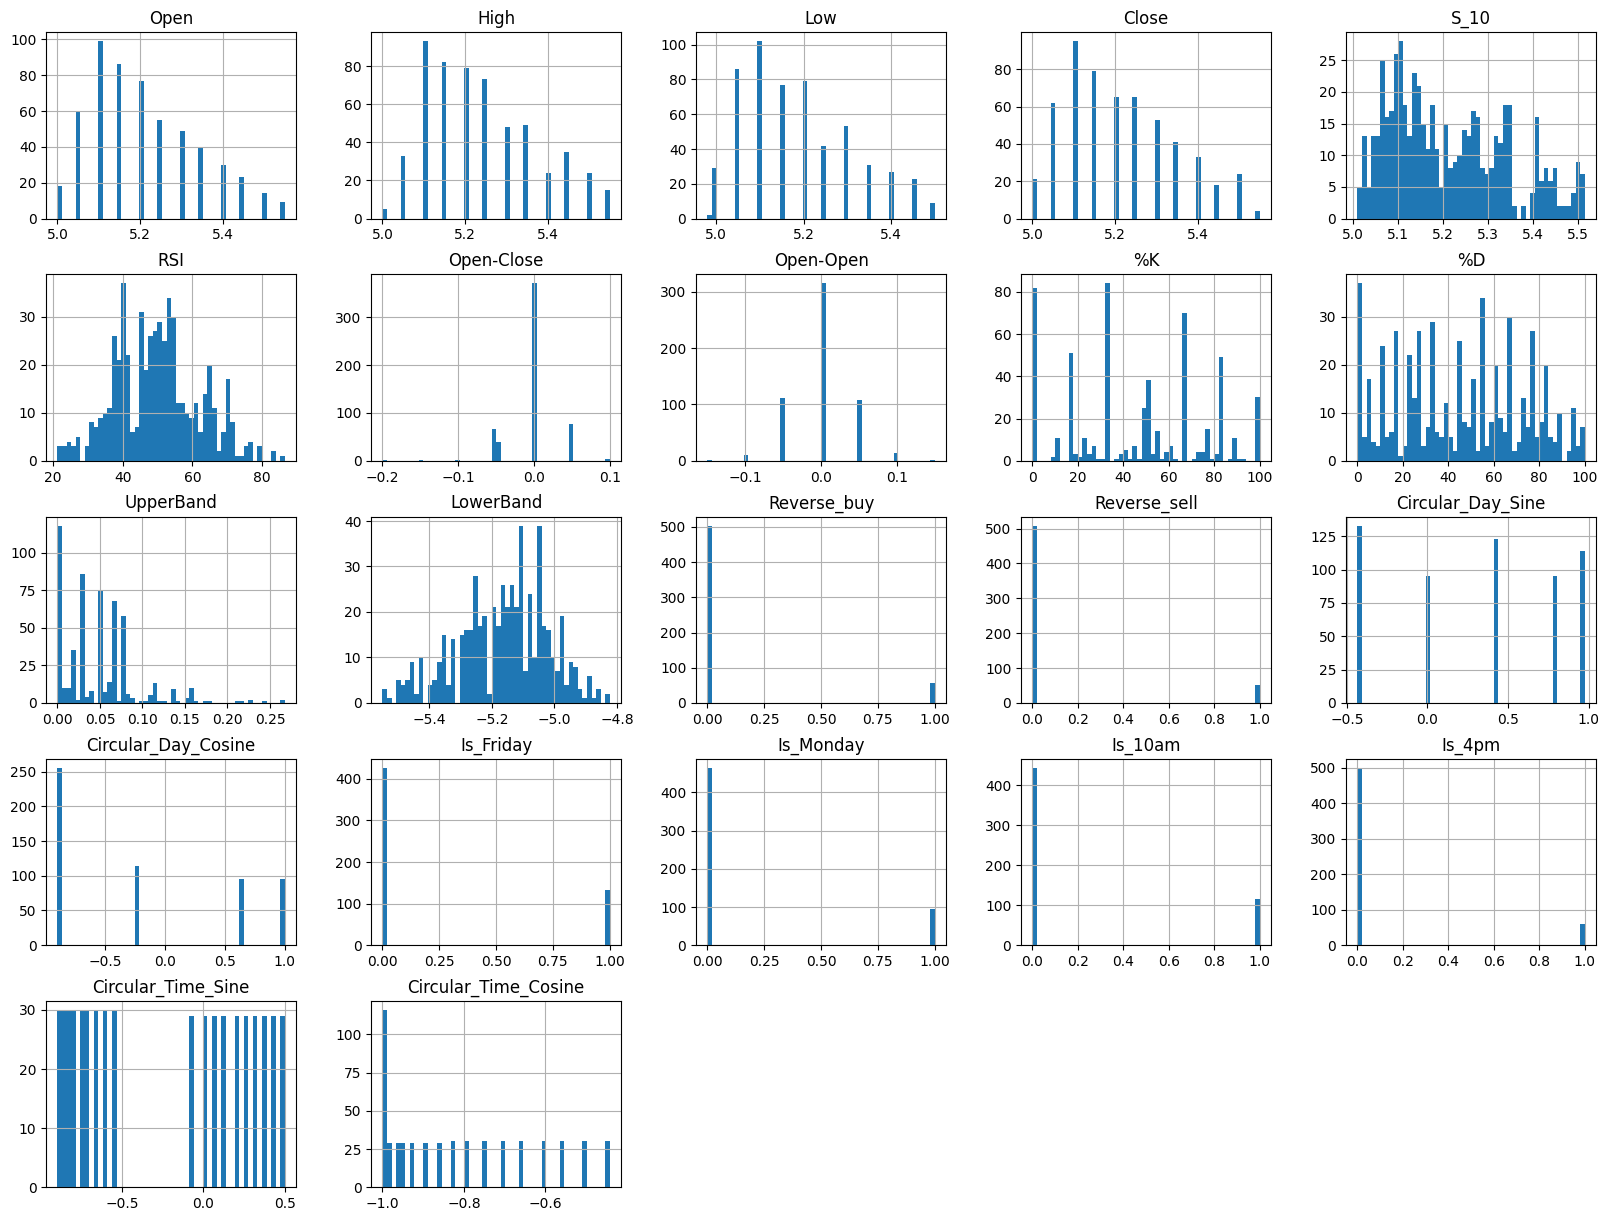

In [ ]:
# EDA - Normality distribution of feature
df_train.hist(bins=50, figsize=(20,15))
plt.show()